In [1]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=dba0395b80cb92f6b86e6fb11e8b7a57f9a9731f4d545952ad797d28ac806d40
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import pandas as pd
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [3]:
customer=pd.read_csv('/content/customer_data.csv')
customer.head()

label        id  fea_1   fea_2  fea_3     fea_4  fea_5  fea_6  fea_7  \
0      1  54982665      5  1245.5      3   77000.0      2     15      5   
1      0  59004779      4  1277.0      1  113000.0      2      8     -1   
2      0  58990862      7  1298.0      1  110000.0      2     11     -1   
3      1  58995168      7  1335.5      1  151000.0      2     11      5   
4      0  54987320      7     NaN      2   59000.0      2     11      5   

   fea_8  fea_9  fea_10      fea_11  
0    109      5  151300  244.948974  
1    100      3  341759  207.173840  
2    101      5   72001    1.000000  
3    110      3   60084    1.000000  
4    108      4  450081  197.403141

In [4]:
payment=pd.read_csv('/content/payment_data.csv')
payment.head()

id  OVD_t1  OVD_t2  OVD_t3  OVD_sum  pay_normal  prod_code  \
0  58987402       0       0       0        0           1         10   
1  58995151       0       0       0        0           1          5   
2  58997200       0       0       0        0           2          5   
3  54988608       0       0       0        0           3         10   
4  54987763       0       0       0        0           2         10   

   prod_limit update_date  new_balance  highest_balance report_date  
0     16500.0  04/12/2016          0.0              NaN         NaN  
1         NaN  04/12/2016     588720.0         491100.0         NaN  
2         NaN  04/12/2016     840000.0         700500.0  22/04/2016  
3     37400.0  03/12/2016       8425.2           7520.0  25/04/2016  
4         NaN  03/12/2016      15147.6              NaN  26/04/2016

In [5]:
def riskfact(x):
    if x==1:
        return 'High_Risk'
    else:
        return 'Low_Risk'
customer['Risks']=customer['label'].apply(riskfact)
customer.head()

label        id  fea_1   fea_2  fea_3     fea_4  fea_5  fea_6  fea_7  \
0      1  54982665      5  1245.5      3   77000.0      2     15      5   
1      0  59004779      4  1277.0      1  113000.0      2      8     -1   
2      0  58990862      7  1298.0      1  110000.0      2     11     -1   
3      1  58995168      7  1335.5      1  151000.0      2     11      5   
4      0  54987320      7     NaN      2   59000.0      2     11      5   

   fea_8  fea_9  fea_10      fea_11      Risks  
0    109      5  151300  244.948974  High_Risk  
1    100      3  341759  207.173840   Low_Risk  
2    101      5   72001    1.000000   Low_Risk  
3    110      3   60084    1.000000  High_Risk  
4    108      4  450081  197.403141   Low_Risk

In [6]:
customer['Risks'].value_counts()

Low_Risk     900
High_Risk    225
Name: Risks, dtype: int64

In [7]:
customer.drop(['fea_2'],axis=1,inplace=True)
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1125 non-null   int64  
 1   id      1125 non-null   int64  
 2   fea_1   1125 non-null   int64  
 3   fea_3   1125 non-null   int64  
 4   fea_4   1125 non-null   float64
 5   fea_5   1125 non-null   int64  
 6   fea_6   1125 non-null   int64  
 7   fea_7   1125 non-null   int64  
 8   fea_8   1125 non-null   int64  
 9   fea_9   1125 non-null   int64  
 10  fea_10  1125 non-null   int64  
 11  fea_11  1125 non-null   float64
 12  Risks   1125 non-null   object 
dtypes: float64(2), int64(10), object(1)
memory usage: 114.4+ KB


In [8]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8250 non-null   int64  
 1   OVD_t1           8250 non-null   int64  
 2   OVD_t2           8250 non-null   int64  
 3   OVD_t3           8250 non-null   int64  
 4   OVD_sum          8250 non-null   int64  
 5   pay_normal       8250 non-null   int64  
 6   prod_code        8250 non-null   int64  
 7   prod_limit       2132 non-null   float64
 8   update_date      8224 non-null   object 
 9   new_balance      8250 non-null   float64
 10  highest_balance  7841 non-null   float64
 11  report_date      7136 non-null   object 
dtypes: float64(3), int64(7), object(2)
memory usage: 773.6+ KB


<ipython-input-9-73762ea1f87a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(customer.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(10,100,n=200))


<Axes: >

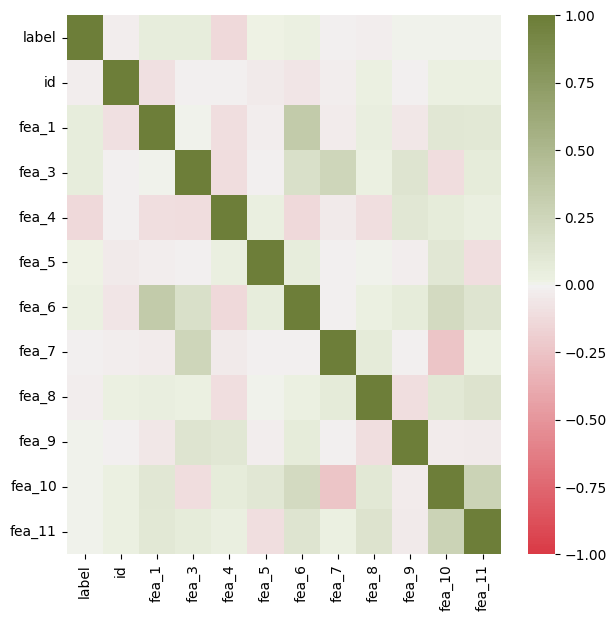

In [9]:
plt.figure(figsize=(7,7))
sns.heatmap(customer.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(10,100,n=200))

<ipython-input-10-f3d68773f46f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(payment.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(20,200,n=200))


<Axes: >

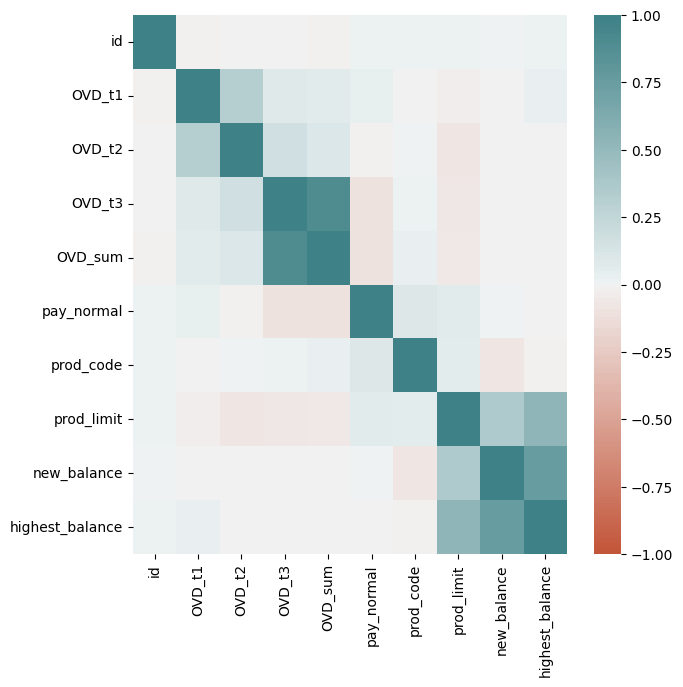

In [10]:
plt.figure(figsize=(7,7))
sns.heatmap(payment.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(20,200,n=200))

In [11]:
cuspay=pd.merge(customer,payment,on='id')
cuspay=cuspay.set_index('id')
cuspay=cuspay.drop(['prod_limit','OVD_t3','new_balance'],axis=1)
cuspay=cuspay.dropna()
cuspay.head()

label  fea_1  fea_3     fea_4  fea_5  fea_6  fea_7  fea_8  fea_9  \
id                                                                           
54982665      1      5      3   77000.0      2     15      5    109      5   
54982665      1      5      3   77000.0      2     15      5    109      5   
54982665      1      5      3   77000.0      2     15      5    109      5   
59004779      0      4      1  113000.0      2      8     -1    100      3   
59004779      0      4      1  113000.0      2      8     -1    100      3   

          fea_10      fea_11      Risks  OVD_t1  OVD_t2  OVD_sum  pay_normal  \
id                                                                             
54982665  151300  244.948974  High_Risk       0       0        0           9   
54982665  151300  244.948974  High_Risk       0       0        0          18   
54982665  151300  244.948974  High_Risk       0       2    11906           6   
59004779  341759  207.173840   Low_Risk       0       0        0           4   
59004779  341759  207.173840   Low_Risk       0       0        0           5   

          prod_code update_date  highest_balance report_date  
id                                                            
54982665         10  31/01/2015          18934.0  19/09/2015  
54982665         10  28/04/2009         149387.0  10/08/2015  
54982665         10  17/05/2007          46371.0  12/07/2013  
59004779          6  02/06/2016          21500.0  19/04/2016  
59004779          6  17/12/2015          14500.0  19/04/2016

In [12]:
cuspay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6989 entries, 54982665 to 54989781
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label            6989 non-null   int64  
 1   fea_1            6989 non-null   int64  
 2   fea_3            6989 non-null   int64  
 3   fea_4            6989 non-null   float64
 4   fea_5            6989 non-null   int64  
 5   fea_6            6989 non-null   int64  
 6   fea_7            6989 non-null   int64  
 7   fea_8            6989 non-null   int64  
 8   fea_9            6989 non-null   int64  
 9   fea_10           6989 non-null   int64  
 10  fea_11           6989 non-null   float64
 11  Risks            6989 non-null   object 
 12  OVD_t1           6989 non-null   int64  
 13  OVD_t2           6989 non-null   int64  
 14  OVD_sum          6989 non-null   int64  
 15  pay_normal       6989 non-null   int64  
 16  prod_code        6989 non-null   int64  
 17  upd

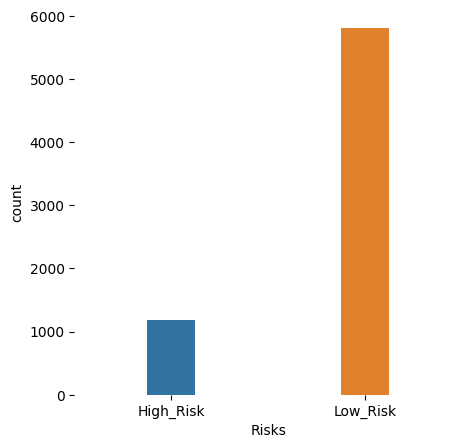

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(data=cuspay,x='Risks',width=0.25)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


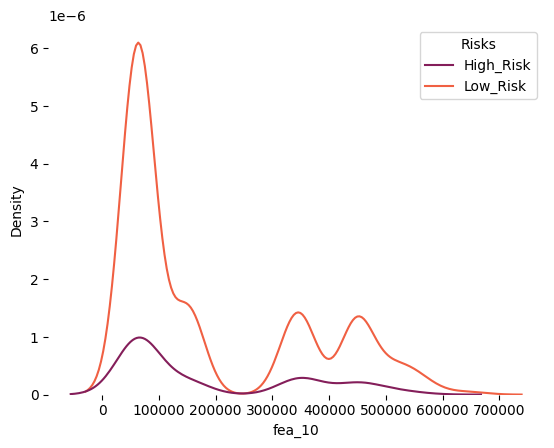

In [14]:
sns.kdeplot(data=cuspay, x="fea_10",hue='Risks',palette='rocket')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)

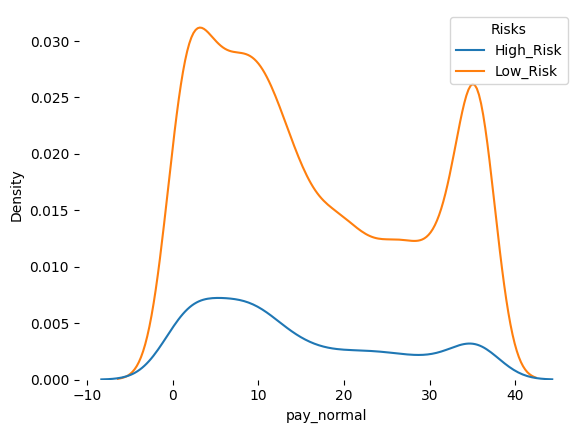

In [15]:
sns.kdeplot(data=cuspay, x="pay_normal",hue='Risks')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)

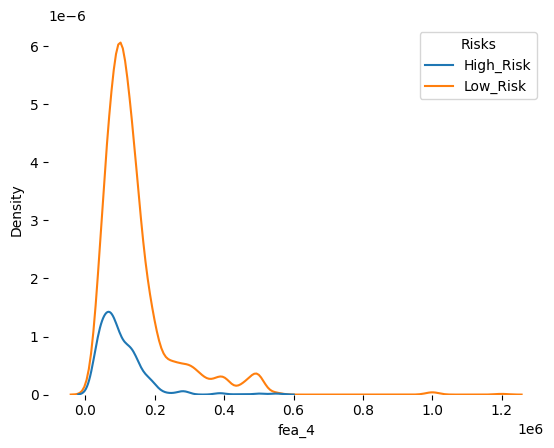

In [16]:
sns.kdeplot(data=cuspay, x="fea_4",hue='Risks')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)

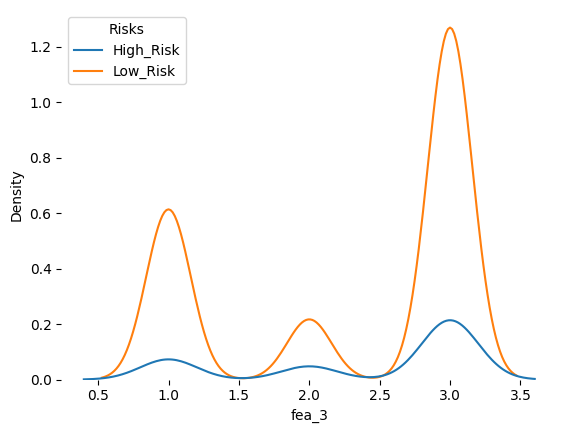

In [17]:
sns.kdeplot(data=cuspay, x="fea_3",hue='Risks')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)

<ipython-input-18-4dcdbf237b7d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(cuspay.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(100,100,n=200),annot=True)


<Axes: >

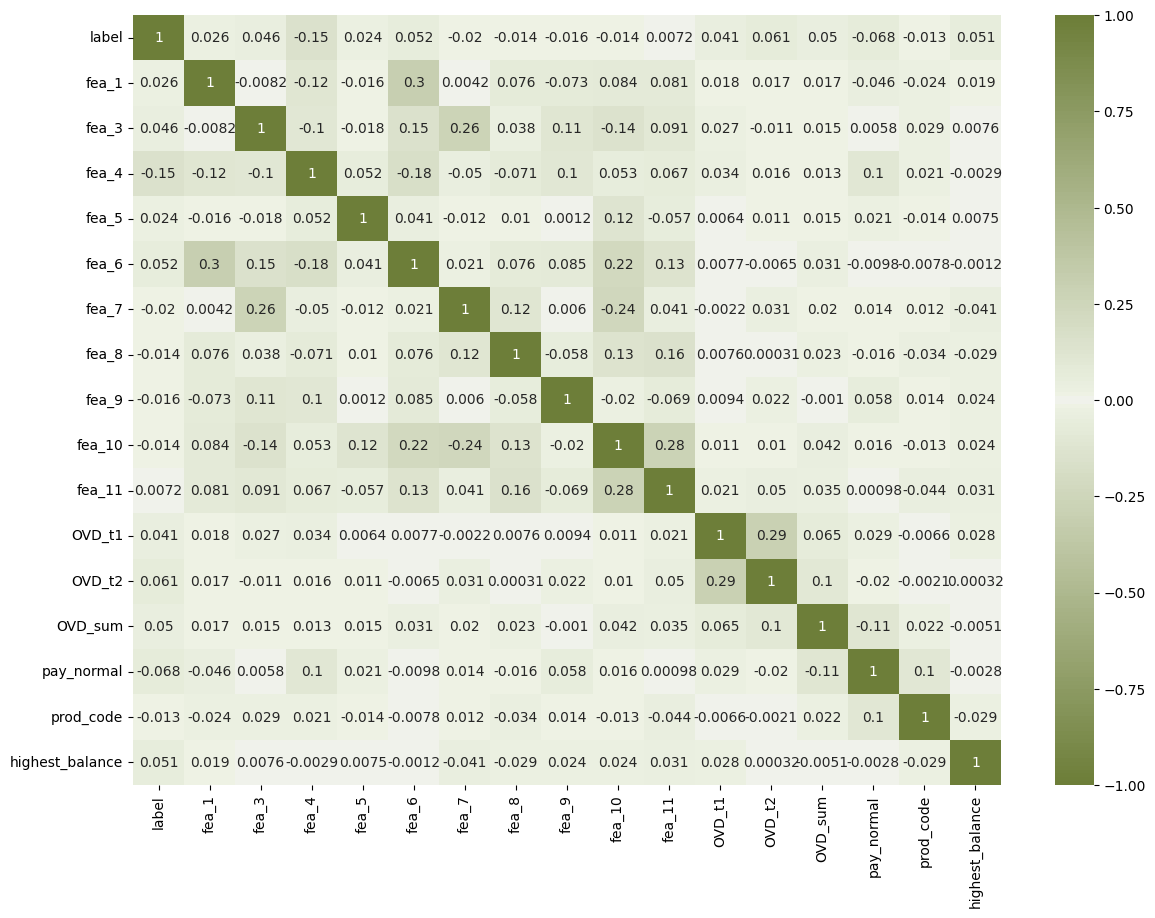

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(cuspay.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(100,100,n=200),annot=True)

In [19]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score, recall_score, f1_score,roc_auc_score,classification_report,ConfusionMatrixDisplay,RocCurveDisplay

In [20]:
from sklearn.model_selection import train_test_split,cross_val_score
X=cuspay[['fea_1','fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8','fea_9', 'fea_10', 'fea_11', 'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal', 'prod_code', 'highest_balance']]
y=cuspay[['label']]



In [21]:
ada = ADASYN(random_state=42)
xs,ys=ada.fit_resample(X,y)
xs_train,xs_test,ys_train,ys_test=train_test_split(xs,ys,test_size=0.35,random_state=0)

In [22]:
tl = CondensedNearestNeighbour(n_neighbors=1)
X_res, y_res = tl.fit_resample(X, y)
X_res_train,X_res_test,y_res_train,y_res_test=train_test_split(X_res,y_res,test_size=0.35,random_state=0)

In [23]:
Y=cuspay[['Risks']]

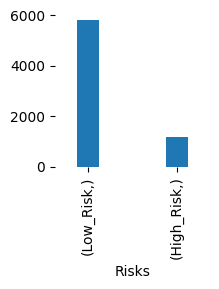

In [24]:
plt.figure(figsize=(2,2))
Y.value_counts().plot(kind='bar',width=0.25)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


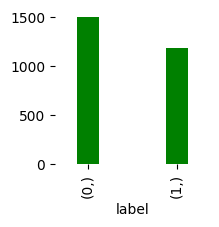

In [25]:
plt.figure(figsize=(2,2))
y_res.value_counts().plot(kind='bar',width=0.25,color='Green')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


NEAR-MISS


In [26]:
tmok=NearMiss()
z,a=tmok.fit_resample(X,y)
z_train,z_test,a_train,a_test=train_test_split(z,a,test_size=0.35,random_state=0)

<ipython-input-27-91129e6c02f7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r_forest_tmok.fit(z_train,a_train)


Accuracy : 0.879
F1 Score : 0.879
Recall : 0.879
Precision : 0.879
              precision    recall  f1-score   support

           0     0.8894    0.8681    0.8786       417
           1     0.8681    0.8894    0.8786       407

    accuracy                         0.8786       824
   macro avg     0.8788    0.8788    0.8786       824
weighted avg     0.8789    0.8786    0.8786       824



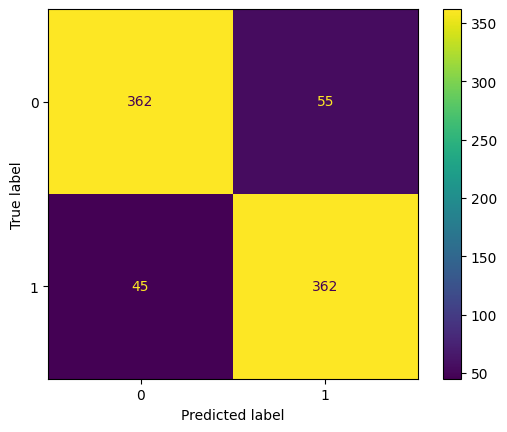

In [27]:
r_forest_tmok = RandomForestClassifier()
r_forest_tmok.fit(z_train,a_train)
Acc_ran_tmok=round(accuracy_score(a_test,r_forest_tmok.predict(z_test)),3)
f1_ran_tmok=round(f1_score(a_test,r_forest_tmok.predict(z_test),average='weighted'),3)
recall_ran_tmok=round(recall_score(a_test,r_forest_tmok.predict(z_test),average='weighted'),3)
precision_ran_tmok=round(precision_score(a_test,r_forest_tmok.predict(z_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_ran_tmok))
print('F1 Score : %.3f' % (f1_ran_tmok))
print('Recall : %.3f' % (recall_ran_tmok))
print('Precision : %.3f' % (precision_ran_tmok))
classification_tmok=classification_report(
    digits=4,
    y_true=a_test,
    y_pred=r_forest_tmok.predict(z_test))
print(classification_tmok)
ConfusionMatrixDisplay.from_estimator(r_forest_tmok, z_test, a_test)
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.62
F1_Score: 0.578
Recall_Score: 0.62
Precision_Score: 0.692
              precision    recall  f1-score   support

           0     0.5774    0.9305    0.7126       417
           1     0.8092    0.3022    0.4401       407

    accuracy                         0.6201       824
   macro avg     0.6933    0.6163    0.5763       824
weighted avg     0.6919    0.6201    0.5780       824



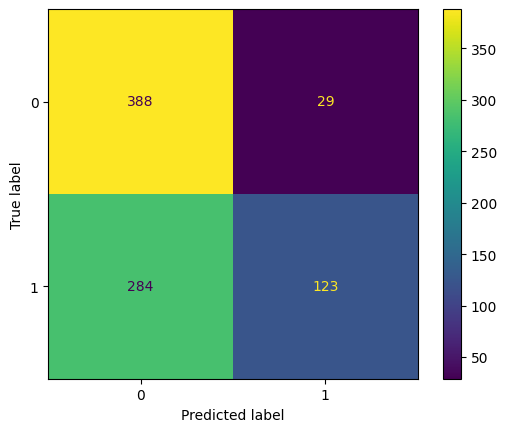

In [28]:
svm_tmok=SVC().fit(z_train,a_train)
Acc_svm_tmok=round(accuracy_score(a_test,svm_tmok.predict(z_test)),3)
f1_svm_tmok=round(f1_score(a_test,svm_tmok.predict(z_test),average='weighted'),3)
recall_svm_tmok=round(recall_score(a_test,svm_tmok.predict(z_test),average='weighted'),3)
precision_svm_tmok=round(precision_score(a_test,svm_tmok.predict(z_test),average='weighted'),3)
print('Accuracy:',Acc_svm_tmok)
print('F1_Score:',f1_svm_tmok)
print('Recall_Score:',recall_svm_tmok)
print('Precision_Score:',precision_svm_tmok)
classification_tmok=classification_report(
    digits=4,
    y_true=a_test,
    y_pred=svm_tmok.predict(z_test))
print(classification_tmok)
ConfusionMatrixDisplay.from_estimator(svm_tmok, z_test, a_test)
plt.show()

Accuracy : 0.914
F1 Score : 0.914
Recall : 0.914
Precision : 0.914
              precision    recall  f1-score   support

           0     0.9179    0.9113    0.9146       417
           1     0.9098    0.9165    0.9131       407

    accuracy                         0.9138       824
   macro avg     0.9138    0.9139    0.9138       824
weighted avg     0.9139    0.9138    0.9138       824



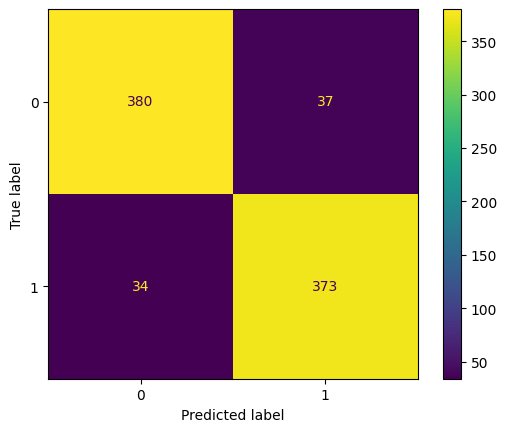

In [29]:
xgb_tmok = XGBClassifier()
xgb_tmok.fit(z_train,a_train)
Acc_xgb_tmok=round(accuracy_score(a_test,xgb_tmok.predict(z_test)),3)
f1_xgb_tmok=round(f1_score(a_test,xgb_tmok.predict(z_test),average='weighted'),3)
recall_xgb_tmok=round(recall_score(a_test,xgb_tmok.predict(z_test),average='weighted'),3)
precision_xgb_tmok=round(precision_score(a_test,xgb_tmok.predict(z_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_xgb_tmok))
print('F1 Score : %.3f' % (f1_xgb_tmok))
print('Recall : %.3f' % (recall_xgb_tmok))
print('Precision : %.3f' % (precision_xgb_tmok))
classification_tmok=classification_report(
    digits=4,
    y_true=a_test,
    y_pred=xgb_tmok.predict(z_test))
print(classification_tmok)
ConfusionMatrixDisplay.from_estimator(xgb_tmok, z_test, a_test)
plt.show()



SMOTE

In [30]:
smote=SMOTE()
x,y=smote.fit_resample(X,y)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.35,random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


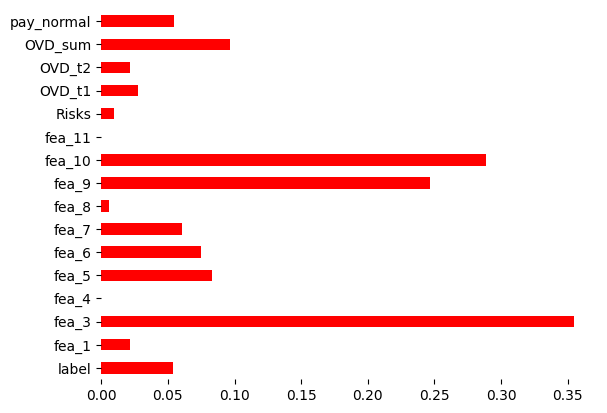

In [31]:
imp=mutual_info_classif(x,y)
feat=pd.Series(imp,cuspay.columns[0:16])
feat.plot(kind='barh',color='red')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.show()

<ipython-input-32-0f478aea112e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r_forest_smot.fit(x_train,y_train)


Accuracy : 0.971
F1 Score : 0.971
Recall : 0.971
Precision : 0.972
              precision    recall  f1-score   support

           0     0.9600    0.9825    0.9711      2002
           1     0.9827    0.9603    0.9714      2068

    accuracy                         0.9713      4070
   macro avg     0.9713    0.9714    0.9713      4070
weighted avg     0.9715    0.9713    0.9713      4070



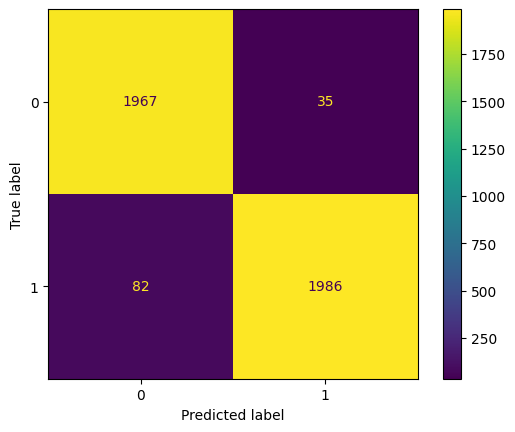

In [32]:
r_forest_smot = RandomForestClassifier()
r_forest_smot.fit(x_train,y_train)
Acc_ran_smot=round(accuracy_score(y_test,r_forest_smot.predict(x_test)),3)
f1_ran_smot=round(f1_score(y_test,r_forest_smot.predict(x_test),average='weighted'),3)
recall_ran_smot=round(recall_score(y_test,r_forest_smot.predict(x_test),average='weighted'),3)
precision_ran_smot=round(precision_score(y_test,r_forest_smot.predict(x_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_ran_smot))
print('F1 Score : %.3f' % (f1_ran_smot))
print('Recall : %.3f' % (recall_ran_smot))
print('Precision : %.3f' % (precision_ran_smot))
classification_smot=classification_report(
    digits=4,
    y_true=y_test,
    y_pred=r_forest_smot.predict(x_test))
print(classification_smot)
ConfusionMatrixDisplay.from_estimator(r_forest_smot, x_test, y_test)
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.568
F1_Score: 0.492
Recall_Score: 0.568
Precision_Score: 0.649
              precision    recall  f1-score   support

           0     0.7591    0.1778    0.2881      2002
           1     0.5429    0.9454    0.6897      2068

    accuracy                         0.5678      4070
   macro avg     0.6510    0.5616    0.4889      4070
weighted avg     0.6492    0.5678    0.4922      4070



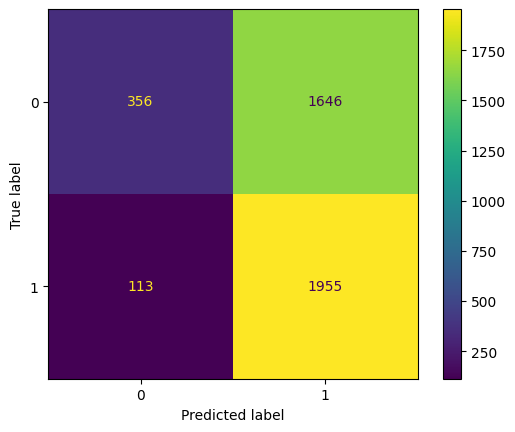

In [33]:
svm_smot=SVC().fit(x_train,y_train)
Acc_svm_smot=round(accuracy_score(y_test,svm_smot.predict(x_test)),3)
f1_svm_smot=round(f1_score(y_test,svm_smot.predict(x_test),average='weighted'),3)
recall_svm_smot=round(recall_score(y_test,svm_smot.predict(x_test),average='weighted'),3)
precision_svm_smot=round(precision_score(y_test,svm_smot.predict(x_test),average='weighted'),3)
print('Accuracy:',Acc_svm_smot)
print('F1_Score:',f1_svm_smot)
print('Recall_Score:',recall_svm_smot)
print('Precision_Score:',precision_svm_smot)
classification_smot=classification_report(
    digits=4,
    y_true=y_test,
    y_pred=svm_smot.predict(x_test))
print(classification_smot)
ConfusionMatrixDisplay.from_estimator(svm_smot, x_test, y_test)
plt.show()

Accuracy : 0.983
F1 Score : 0.983
Recall : 0.983
Precision : 0.983
              precision    recall  f1-score   support

           0     0.9731    0.9925    0.9827      2002
           1     0.9926    0.9734    0.9829      2068

    accuracy                         0.9828      4070
   macro avg     0.9828    0.9830    0.9828      4070
weighted avg     0.9830    0.9828    0.9828      4070



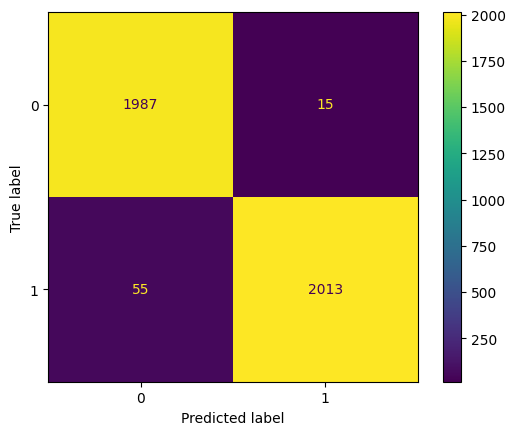

In [34]:
xgb_smot = XGBClassifier()
xgb_smot.fit(x_train,y_train)
Acc_xgb_smot=round(accuracy_score(y_test,xgb_smot.predict(x_test)),3)
f1_xgb_smot=round(f1_score(y_test,xgb_smot.predict(x_test),average='weighted'),3)
recall_xgb_smot=round(recall_score(y_test,xgb_smot.predict(x_test),average='weighted'),3)
precision_xgb_smot=round(precision_score(y_test,xgb_smot.predict(x_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_xgb_smot))
print('F1 Score : %.3f' % (f1_xgb_smot))
print('Recall : %.3f' % (recall_xgb_smot))
print('Precision : %.3f' % (precision_xgb_smot))
classification_smot=classification_report(
    digits=4,
    y_true=y_test,
    y_pred=xgb_smot.predict(x_test))
print(classification_smot)
ConfusionMatrixDisplay.from_estimator(xgb_smot, x_test, y_test)
plt.show()



In [35]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names=[0,1],
    mode='classification'
)
exp = explainer.explain_instance(
    data_row=x_test.iloc[27], 
    predict_fn=xgb_smot.predict_proba
)

exp.show_in_notebook(show_table=True)

In [36]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names=[0,1],
    mode='classification'
)
exp = explainer.explain_instance(
    data_row=x_test.iloc[1], 
    predict_fn=xgb_smot.predict_proba
)

exp.show_in_notebook(show_table=True)

ADASYN

<ipython-input-37-cbf93426a87e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r_forest_ada.fit(xs_train,ys_train)


Accuracy : 0.962
F1 Score : 0.962
Recall : 0.962
Precision : 0.962
              precision    recall  f1-score   support

           0     0.9542    0.9680    0.9610      2000
           1     0.9695    0.9563    0.9629      2129

    accuracy                         0.9620      4129
   macro avg     0.9618    0.9622    0.9620      4129
weighted avg     0.9621    0.9620    0.9620      4129



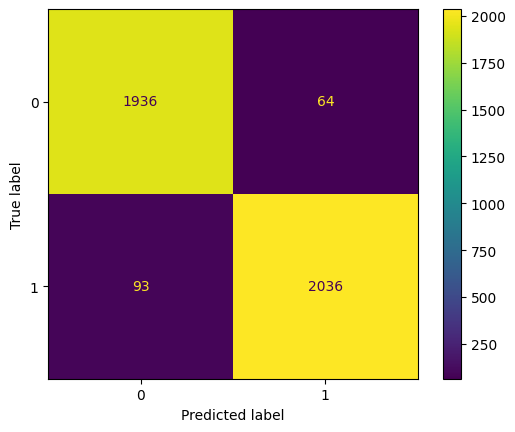

In [37]:
r_forest_ada = RandomForestClassifier()
r_forest_ada.fit(xs_train,ys_train)
Acc_ran_ada=round(accuracy_score(ys_test,r_forest_ada.predict(xs_test)),3)
f1_ran_ada=round(f1_score(ys_test,r_forest_ada.predict(xs_test),average='weighted'),3)
recall_ran_ada=round(recall_score(ys_test,r_forest_ada.predict(xs_test),average='weighted'),3)
precision_ran_ada=round(precision_score(ys_test,r_forest_ada.predict(xs_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_ran_ada))
print('F1 Score : %.3f' % (f1_ran_ada))
print('Recall : %.3f' % (recall_ran_ada))
print('Precision : %.3f' % (precision_ran_ada))
classification_ada=classification_report(
    digits=4,
    y_true=ys_test,
    y_pred=r_forest_ada.predict(xs_test))
print(classification_ada)
ConfusionMatrixDisplay.from_estimator(r_forest_ada, xs_test, ys_test)
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.583
F1_Score: 0.564
Recall_Score: 0.583
Precision_Score: 0.592
              precision    recall  f1-score   support

           0     0.6151    0.3715    0.4632      2000
           1     0.5697    0.7816    0.6590      2129

    accuracy                         0.5829      4129
   macro avg     0.5924    0.5765    0.5611      4129
weighted avg     0.5917    0.5829    0.5642      4129



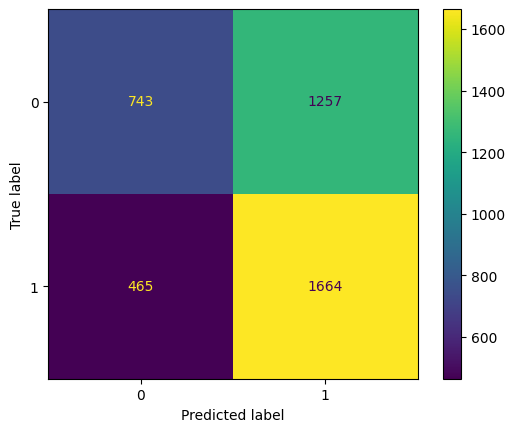

In [38]:
svm_ada=SVC().fit(xs_train,ys_train)
Acc_svm_ada=round(accuracy_score(ys_test,svm_ada.predict(xs_test)),3)
f1_svm_ada=round(f1_score(ys_test,svm_ada.predict(xs_test),average='weighted'),3)
recall_svm_ada=round(recall_score(ys_test,svm_ada.predict(xs_test),average='weighted'),3)
precision_svm_ada=round(precision_score(ys_test,svm_ada.predict(xs_test),average='weighted'),3)
print('Accuracy:',Acc_svm_ada)
print('F1_Score:',f1_svm_ada)
print('Recall_Score:',recall_svm_ada)
print('Precision_Score:',precision_svm_ada)
classification_ada=classification_report(
    digits=4,
    y_true=ys_test,
    y_pred=svm_ada.predict(xs_test))
print(classification_ada)
ConfusionMatrixDisplay.from_estimator(svm_ada, xs_test, ys_test)
plt.show()

Accuracy : 0.984
F1 Score : 0.984
Recall : 0.984
Precision : 0.984
              precision    recall  f1-score   support

           0     0.9721    0.9945    0.9832      2000
           1     0.9947    0.9732    0.9839      2129

    accuracy                         0.9835      4129
   macro avg     0.9834    0.9839    0.9835      4129
weighted avg     0.9838    0.9835    0.9835      4129



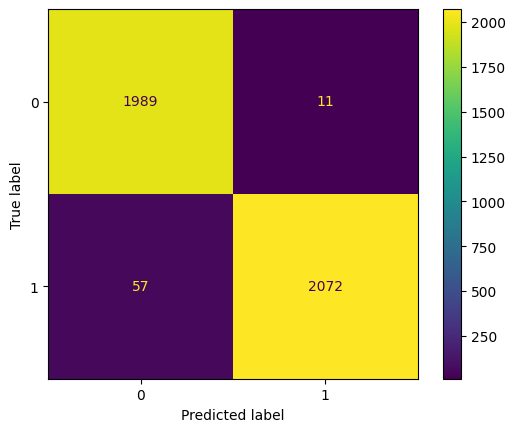

In [39]:
xgb_ada = XGBClassifier()
xgb_ada.fit(xs_train,ys_train)
Acc_xgb_ada=round(accuracy_score(ys_test,xgb_ada.predict(xs_test)),3)
f1_xgb_ada=round(f1_score(ys_test,xgb_ada.predict(xs_test),average='weighted'),3)
recall_xgb_ada=round(recall_score(ys_test,xgb_ada.predict(xs_test),average='weighted'),3)
precision_xgb_ada=round(precision_score(ys_test,xgb_ada.predict(xs_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_xgb_ada))
print('F1 Score : %.3f' % (f1_xgb_ada))
print('Recall : %.3f' % (recall_xgb_ada))
print('Precision : %.3f' % (precision_xgb_ada))
classification_ada=classification_report(
    digits=4,
    y_true=ys_test,
    y_pred=xgb_ada.predict(xs_test))
print(classification_ada)
ConfusionMatrixDisplay.from_estimator(xgb_ada, xs_test, ys_test)
plt.show()



TOMEKLINKS

In [40]:
# tl = TomekLinks()
# X_res, y_res = tl.fit_resample(X, y)
# X_res_train,X_res_test,y_res_train,y_res_test=train_test_split(X_res,y_res,test_size=0.35,random_state=0)

<ipython-input-41-ff2fa19f6d65>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r_forest_tl.fit(X_res_train,y_res_train)


Accuracy : 0.901
F1 Score : 0.900
Recall : 0.901
Precision : 0.901
              precision    recall  f1-score   support

           0     0.8893    0.9387    0.9133       522
           1     0.9169    0.8527    0.8836       414

    accuracy                         0.9006       936
   macro avg     0.9031    0.8957    0.8985       936
weighted avg     0.9015    0.9006    0.9002       936



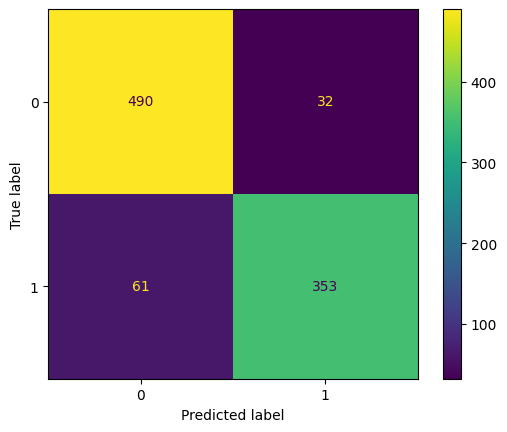

In [41]:
r_forest_tl = RandomForestClassifier()
r_forest_tl.fit(X_res_train,y_res_train)
Acc_ran_tl=round(accuracy_score(y_res_test,r_forest_tl.predict(X_res_test)),3)
f1_ran_tl=round(f1_score(y_res_test,r_forest_tl.predict(X_res_test),average='weighted'),3)
recall_ran_tl=round(recall_score(y_res_test,r_forest_tl.predict(X_res_test),average='weighted'),3)
precision_ran_tl=round(precision_score(y_res_test,r_forest_tl.predict(X_res_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_ran_tl))
print('F1 Score : %.3f' % (f1_ran_tl))
print('Recall : %.3f' % (recall_ran_tl))
print('Precision : %.3f' % (precision_ran_tl))
classification_tl=classification_report(
    digits=4,
    y_true=y_res_test,
    y_pred=r_forest_tl.predict(X_res_test))
print(classification_tl)
ConfusionMatrixDisplay.from_estimator(r_forest_tl, X_res_test, y_res_test)
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.559
F1_Score: 0.407
Recall_Score: 0.559
Precision_Score: 0.564
              precision    recall  f1-score   support

           0     0.5587    0.9943    0.7154       522
           1     0.5714    0.0097    0.0190       414

    accuracy                         0.5588       936
   macro avg     0.5650    0.5020    0.3672       936
weighted avg     0.5643    0.5588    0.4074       936



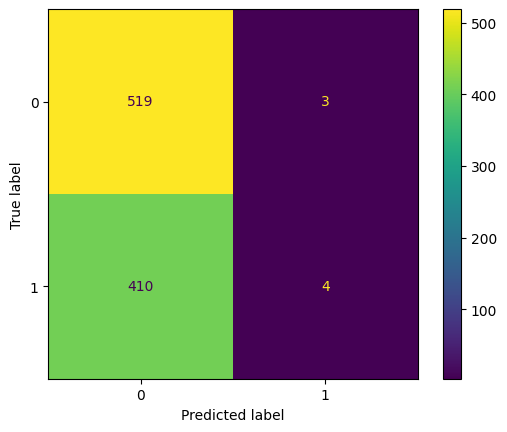

In [42]:
svm_tl=SVC().fit(X_res_train,y_res_train)
Acc_svm_tl=round(accuracy_score(y_res_test,svm_tl.predict(X_res_test)),3)
f1_svm_tl=round(f1_score(y_res_test,svm_tl.predict(X_res_test),average='weighted'),3)
recall_svm_tl=round(recall_score(y_res_test,svm_tl.predict(X_res_test),average='weighted'),3)
precision_svm_tl=round(precision_score(y_res_test,svm_tl.predict(X_res_test),average='weighted'),3)
print('Accuracy:',Acc_svm_tl)
print('F1_Score:',f1_svm_tl)
print('Recall_Score:',recall_svm_tl)
print('Precision_Score:',precision_svm_tl)
classification_tl=classification_report(
    digits=4,
    y_true=y_res_test,
    y_pred=svm_tl.predict(X_res_test))
print(classification_tl)
ConfusionMatrixDisplay.from_estimator(svm_tl, X_res_test, y_res_test)
plt.show()

Accuracy : 0.932
F1 Score : 0.932
Recall : 0.932
Precision : 0.932
              precision    recall  f1-score   support

           0     0.9370    0.9406    0.9388       522
           1     0.9248    0.9203    0.9225       414

    accuracy                         0.9316       936
   macro avg     0.9309    0.9305    0.9307       936
weighted avg     0.9316    0.9316    0.9316       936



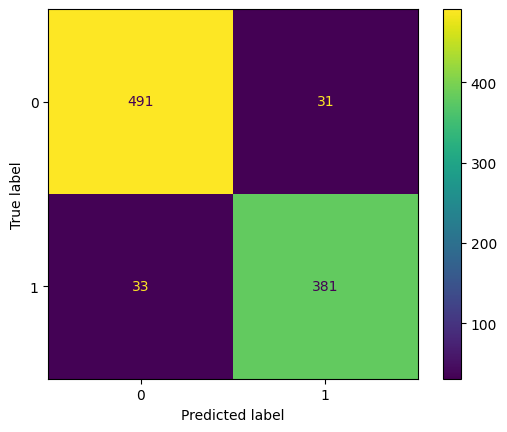

In [43]:
xgb_tl = XGBClassifier()
xgb_tl.fit(X_res_train,y_res_train)
Acc_xgb_tl=round(accuracy_score(y_res_test,xgb_tl.predict(X_res_test)),3)
f1_xgb_tl=round(f1_score(y_res_test,xgb_tl.predict(X_res_test),average='weighted'),3)
recall_xgb_tl=round(recall_score(y_res_test,xgb_tl.predict(X_res_test),average='weighted'),3)
precision_xgb_tl=round(precision_score(y_res_test,xgb_tl.predict(X_res_test),average='weighted'),3)
print('Accuracy : %.3f' % (Acc_xgb_tl))
print('F1 Score : %.3f' % (f1_xgb_tl))
print('Recall : %.3f' % (recall_xgb_tl))
print('Precision : %.3f' % (precision_xgb_tl))
classification_tl=classification_report(
    digits=4,
    y_true=y_res_test,
    y_pred=xgb_tl.predict(X_res_test))
print(classification_tl)
ConfusionMatrixDisplay.from_estimator(xgb_tl, X_res_test, y_res_test)
plt.show()



In [70]:
tl={
                  'Model':['Random-Forest','XGBoost','SVM'],
                  'Accuracy(%)':[Acc_ran_tl*100,Acc_xgb_tl*100,Acc_svm_tl*100],
                  'F1_Score(%)':[f1_ran_tl*100,f1_xgb_tl*100,f1_svm_tl*100],
                  'Precision(%)':[precision_ran_tl*100,precision_xgb_tl*100,precision_svm_tl*100],
                  'Recall(%)':[recall_ran_tl*100,recall_xgb_tl*100,recall_svm_tl*100]
        
                    }
Tlinks=pd.DataFrame(tl)
Tlinks.head()

Model  Accuracy(%)  F1_Score(%)  Precision(%)  Recall(%)
0  Random-Forest         90.1         90.0          90.1       90.1
1        XGBoost         93.2         93.2          93.2       93.2
2            SVM         55.9         40.7          56.4       55.9

In [69]:
adysan={
                  'Model':['Random-Forest','XGBoost','SVM'],
                  'Accuracy(%)':[Acc_ran_ada*100,Acc_xgb_ada*100,Acc_svm_ada*100],
                  'F1_Score(%)':[f1_ran_ada*100,f1_xgb_ada*100,f1_svm_ada*100],
                  'Precision(%)':[precision_ran_ada*100,precision_xgb_ada*100,precision_svm_ada*100],
                  'Recall(%)':[recall_ran_ada*100,recall_xgb_ada*100,recall_svm_ada*100]
        
                    }
ADASYN=pd.DataFrame(adysan)
ADASYN.head()

Model  Accuracy(%)  F1_Score(%)  Precision(%)  Recall(%)
0  Random-Forest         96.2         96.2          96.2       96.2
1        XGBoost         98.4         98.4          98.4       98.4
2            SVM         58.3         56.4          59.2       58.3

In [60]:
Near={
                  'Model':['Random-Forest','XGBoost','SVM'],
                  'Accuracy(%)':[Acc_ran_tmok*100,Acc_xgb_tmok*100,Acc_svm_tmok*100],
                  'F1_Score(%)':[f1_ran_tmok*100,f1_xgb_tmok*100,f1_svm_tmok*100],
                  'Precision(%)':[precision_ran_tmok*100,precision_xgb_tmok*100,precision_svm_tmok*100],
                  'Recall(%)':[recall_ran_tmok*100,recall_xgb_tmok*100,recall_svm_tmok*100]
        
                    }
                    
Nearmiss=pd.DataFrame(Near)
Nearmiss.head()

Model  Accuracy(%)  F1_Score(%)  Precision(%)  Recall(%)
0  Random-Forest         87.9         87.9          87.9       87.9
1        XGBoost         91.4         91.4          91.4       91.4
2            SVM         62.0         57.8          69.2       62.0

In [61]:
Smot={
                  'Model':['Random-Forest','XGBoost','SVM'],
                  'Accuracy(%)':[Acc_ran_smot*100,Acc_xgb_smot*100,Acc_svm_smot*100],
                  'F1_Score(%)':[f1_ran_smot*100,f1_xgb_smot*100,f1_svm_smot*100],
                  'Precision(%)':[precision_ran_smot*100,precision_xgb_smot*100,precision_svm_smot*100],
                  'Recall(%)':[recall_ran_smot*100,recall_xgb_smot*100,recall_svm_smot*100]
        
                    }
                    
Smote=pd.DataFrame(Smot)
Smote.head()

Model  Accuracy(%)  F1_Score(%)  Precision(%)  Recall(%)
0  Random-Forest         97.1         97.1          97.2       97.1
1        XGBoost         98.3         98.3          98.3       98.3
2            SVM         56.8         49.2          64.9       56.8

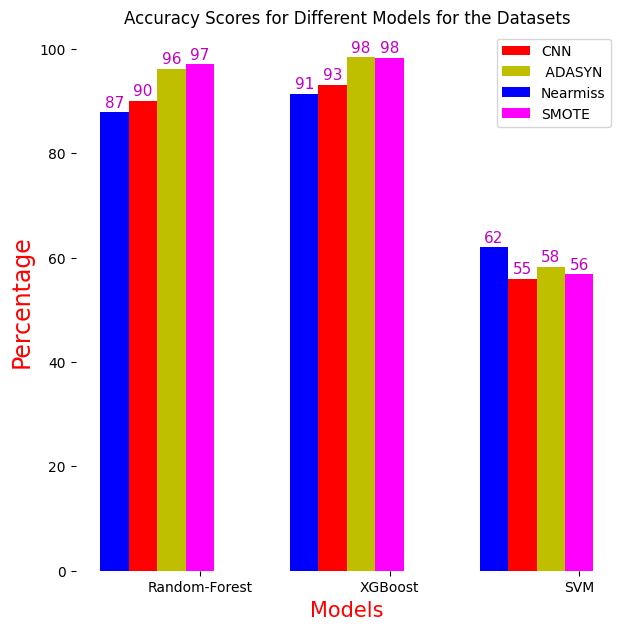

In [71]:
x=['Random-Forest','XGBoost','SVM']
widt=0.15
X=np.arange(len(x))
plt.figure(figsize=(7,7))
bar1=plt.bar(X,Tlinks['Accuracy(%)'],widt,color='r')
bar2=plt.bar(X+widt,ADASYN['Accuracy(%)'],widt,color='y')
bar3=plt.bar(X-widt,Nearmiss['Accuracy(%)'],widt,color='b')
bar4=plt.bar(X+(2)*widt,Smote['Accuracy(%)'],widt,color='magenta')
for bar in bar1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar3:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar4:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
plt.xticks(X+(2*widt),x)
plt.legend( (bar1, bar2, bar3, bar4),('CNN', ' ADASYN', 'Nearmiss','SMOTE'))
plt.title('Accuracy Scores for Different Models for the Datasets')
plt.ylabel('Percentage',fontsize=17,color='red')
plt.xlabel('Models',fontsize=15,color='red')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

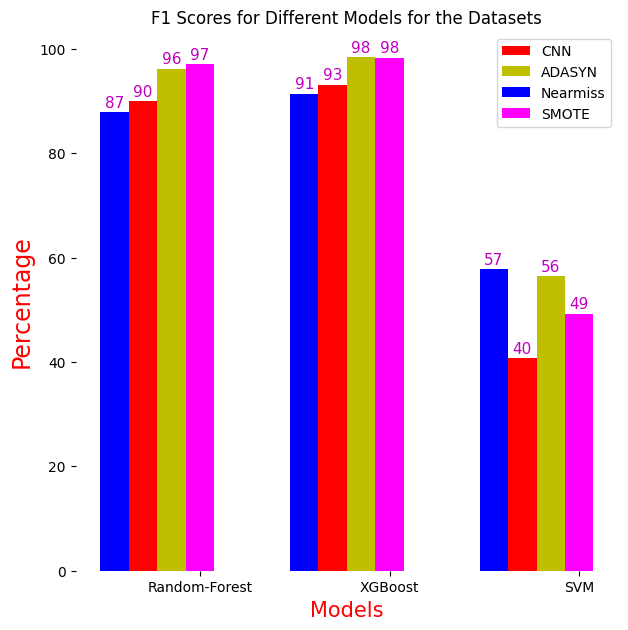

In [72]:
x=['Random-Forest','XGBoost','SVM']
widt=0.15
X=np.arange(len(x))
plt.figure(figsize=(7,7))
bar1=plt.bar(X,Tlinks['F1_Score(%)'],widt,color='r')
bar2=plt.bar(X+widt,ADASYN['F1_Score(%)'],widt,color='y')
bar3=plt.bar(X-widt,Nearmiss['F1_Score(%)'],widt,color='b')
bar4=plt.bar(X+(2)*widt,Smote['F1_Score(%)'],widt,color='magenta')
for bar in bar1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar3:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar4:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
plt.xticks(X+(2*widt),x)
plt.legend( (bar1, bar2, bar3, bar4),('CNN', 'ADASYN', 'Nearmiss','SMOTE'))
plt.title('F1 Scores for Different Models for the Datasets')
plt.ylabel('Percentage',fontsize=17,color='red')
plt.xlabel('Models',fontsize=15,color='red')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

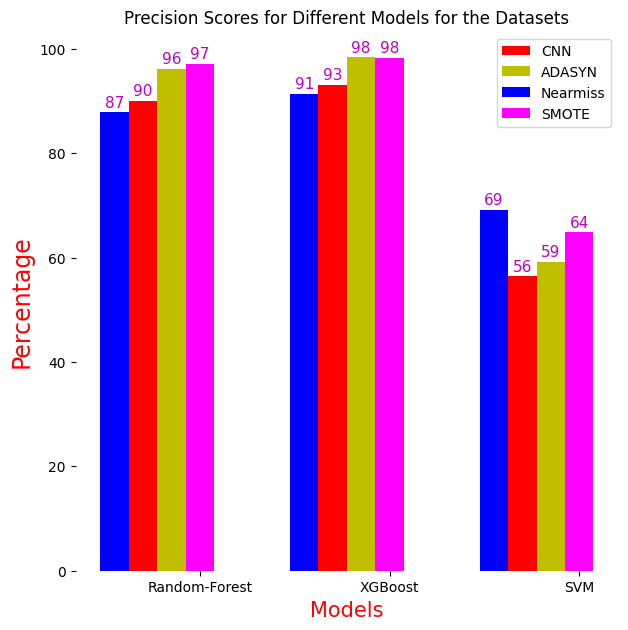

In [73]:
x=['Random-Forest','XGBoost','SVM']
widt=0.15
X=np.arange(len(x))
plt.figure(figsize=(7,7))
bar1=plt.bar(X,Tlinks['Precision(%)'],widt,color='r')
bar2=plt.bar(X+widt,ADASYN['Precision(%)'],widt,color='y')
bar3=plt.bar(X-widt,Nearmiss['Precision(%)'],widt,color='b')
bar4=plt.bar(X+(2)*widt,Smote['Precision(%)'],widt,color='magenta')
for bar in bar1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar3:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar4:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
plt.xticks(X+(2*widt),x)
plt.legend( (bar1, bar2, bar3, bar4),('CNN', 'ADASYN', 'Nearmiss','SMOTE'))
plt.title('Precision Scores for Different Models for the Datasets')
plt.ylabel('Percentage',fontsize=17,color='red')
plt.xlabel('Models',fontsize=15,color='red')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

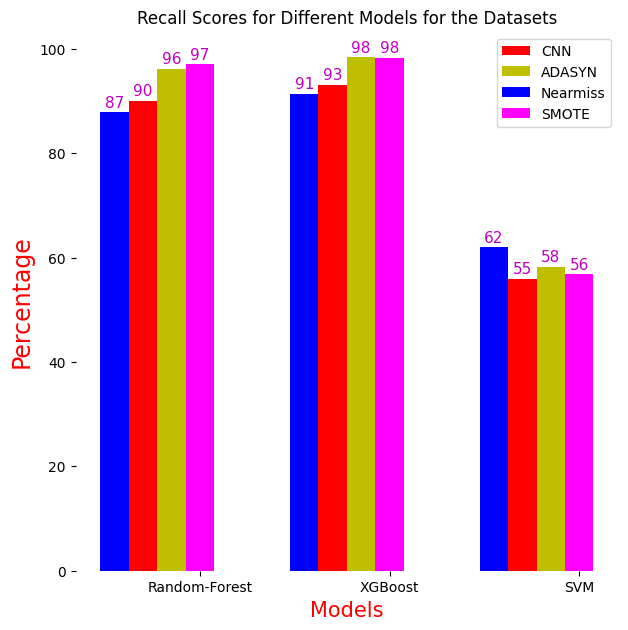

In [74]:
x=['Random-Forest','XGBoost','SVM']
widt=0.15
X=np.arange(len(x))
plt.figure(figsize=(7,7))
bar1=plt.bar(X,Tlinks['Recall(%)'],widt,color='r')
bar2=plt.bar(X+widt,ADASYN['Recall(%)'],widt,color='y')
bar3=plt.bar(X-widt,Nearmiss['Recall(%)'],widt,color='b')
bar4=plt.bar(X+(2)*widt,Smote['Recall(%)'],widt,color='magenta')
for bar in bar1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar3:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
for bar in bar4:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(int(bar.get_height())), 
                 ha='center', color='m', fontsize=11)
plt.xticks(X+(2*widt),x)
plt.legend( (bar1, bar2, bar3, bar4),('CNN', 'ADASYN', 'Nearmiss','SMOTE'))
plt.title('Recall Scores for Different Models for the Datasets')
plt.ylabel('Percentage',fontsize=17,color='red')
plt.xlabel('Models',fontsize=15,color='red')
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()